# Introduction

This notebook is a supplement to Frostig et al. 2021, and describes the steps to create Figures 10, 11 and 12 from the paper. These figures can help observatories select BNS GW triggers that are worth following up during LIGO's O4 observing run (please refer to the paper for additional details). 



In [8]:
from astropy.io import ascii
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib.gridspec import GridSpec
from astropy.table import vstack
from glob import glob
from astropy.table import Table
import pickle
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import colors
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib


from gwemlightcurves.KNModels import KNTable
import numpy as np
import pickle
import sys
from datetime import datetime

mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['text.usetex'] = True

# I. Generate the input files required for calculating the light curve grid

This cell calculates the input parameters for the light curve calculation. The input parameters for the Bulla models are the ejecta masses - M$_{\rm{ej, dyn}}$, M$_{\rm{ej, wind}}$, the opening angle of the dynamical ejecta $\Phi$ and the viewing angle $\Theta_{\rm{obs}}$. The ranges for these parameters are taken from Andreoni et al. 2020

In [3]:
from astropy.table import Table
from gwemlightcurves.KNModels import KNTable
import numpy as np
from astropy.table import Column

Mej_dyn = np.linspace(0.001,0.02,10)
Mej_wind = np.linspace(0.01,0.13,10)

phis = np.array([10,30,45,60,75,90])
costhetas = np.linspace(0,1,5)
thetas = np.arccos(costhetas)*(180/np.pi)


t = Table(names=['mej_dyn','mej_wind','phi','theta'])
for mdyn in Mej_dyn:
    for mwind in Mej_wind:
        for theta in thetas:
            for phi in phis:
                t.add_row([mdyn,mwind,phi,theta])

#Need to add dummy values of the neutron star masses and mass ratios for gwemlightcurves to work, these are not used anywhere
m1 = np.ones(len(t)) 
m2 = np.ones(len(t))
q = m1/m2

t.add_column(Column(name='m1',data=m1))
t.add_column(Column(name='m2',data=m2))
t.add_column(Column(name='q',data=q))

t.write('bns_ejecta_parameters.csv',overwrite=True)

# II. Calculate lightcurves

This step calculates the lightcurves by interpolating through the Bulla models. For this to work, you need to have the Bulla model grid files on your computer, and pass the path to these models as an argument to KNTable.model

This step takes considerable time (and also might eat up quite some RAM). If your machine is short on RAM (the program will crash), you may want to first generate the lightcurves for J band, close the notebook and restar it, and then generate lightcurves again for r band. You can also try splitting the bns_ejecta_parameters.csv file into multiple smaller files and run them separately.

It will produce two files, one for r and J band. The size of each file is ~70 MB.

In [2]:
filts = ['r','J']

t_start = datetime.utcnow()
print('Started at',t_start)

for filt in filts:
#filt = str(sys.argv[1])
#num = str(sys.argv[2])
    t = KNTable.read_samples('bns_ejecta_parameters.csv',Nsamples=100000)


    t['tini'] = 0.01; t['dt']=0.1;t['tmax']=15

    print('Doing filter',filt)
    model_table = KNTable.model('Bu2019lm',t,LoadModel=True,ModelPath='output/svdmodels/',filterlist=[filt])

    pickle.dump(model_table,open('bns_Bulla_parameter_grid_%sband.dat'%(filt),'wb'))

Started at 2022-02-08 22:03:54.747255


/Users/viraj/anaconda3/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/Users/viraj/anaconda3/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


You are requesting to downsample the number of posterior samples to 100000
Doing filter r
n_coeff
-------
     10
     10
     10
     10
     10
     10
     10
     10
     10
     10
    ...
     10
     10
     10
     10
     10
     10
     10
     10
     10
     10
     10
Length = 3000 rows
['r']


FileNotFoundError: [Errno 2] No such file or directory: 'output/svdmodels/Bu2019lm_mag.pkl'

# III. Load in the light curve files

In [3]:
filt = 'r'
with open('output/bns_Bulla_parameter_grid_%sband.dat'%(filt),'rb') as f:
    r = pickle.load(f)
    
filt = 'J'    
with open('output/bns_Bulla_parameter_grid_%sband.dat'%(filt),'rb') as f:
    J = pickle.load(f)
    
peakmags = []
for row in r:
    peakmags.append(np.min(row['mag'][0]))
r['peak_mag'] = peakmags

peakmags = []
for row in J:
    peakmags.append(np.min(row['mag'][0]))
J['peak_mag'] = peakmags

thetas = np.unique(J['theta'])
phis = np.unique(J['phi'])
mej_dyns = np.unique(J['mej_dyn'])
mej_winds = np.unique(J['mej_wind'])

In [4]:
realistic_stats = Table.read('realistic_simulations_stats.csv')
realistic_stats.sort('Distance')
realistic_distances = realistic_stats['Distance']
realistic_costhetas = realistic_stats['costheta']
realistic_area90s = realistic_stats['area90']

# IV. Make Figure 10

Snippet to reproduce Figure 10 in Frostig et al. 2021
Will calculate at what distance a kilonova peaks above the limiting magnitude of the specified telescope

In [11]:
#Set the limiting magnitude for the telescope
m_limiting = 21

Blue
-----
On-axis r-band : 0/13 kilonovae are too far to be detectable for any part of the parameter space
On-axis r-band : 13/13 kilonovae have GW170817 in the detectable region of parameter space
On-axis J-band : 0/13 kilonovae are too far to be detectable for any part of the parameter space
On-axis J-band : 13/13 kilonovae have GW170817 in the detectable region of parameter space
-----


<ipython-input-9-419b70856d39>:72: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax.contour(max_dists[0][0],[max_dists[0][0][3][5]],colors='red',extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='--',linewidth=3)
<ipython-input-9-419b70856d39>:73: UserWarning: No contour levels were found within the data range.
  cs1 = ax.contour(max_dists[0][0],levels=dists_to_plot,extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='-',alpha=0.6,vmin=150,vmax=500,cmap='magma',linewidth=0.7)
<ipython-input-9-419b70856d39>:73: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs1 = ax.contour(max_dists[0][0],levels=dists_to_plot,extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='-',alpha=0.6,vmin=150,vmax=500,cmap='magma',linewidth=0.7)
<ipython-input-9-419b70856d39>:88: UserWarning: The following kwargs were 

Blue
-----
Off-axis r-band : 0/3 kilonovae are too far to be detectable for any part of the parameter space
Off-axis r-band : 3/3 kilonovae have GW170817 in the detectable region of parameter space
Off-axis J-band : 0/3 kilonovae are too far to be detectable for any part of the parameter space
Off-axis J-band : 3/3 kilonovae have GW170817 in the detectable region of parameter space
-----
Red
-----
On-axis r-band : 0/13 kilonovae are too far to be detectable for any part of the parameter space
On-axis r-band : 13/13 kilonovae have GW170817 in the detectable region of parameter space
On-axis J-band : 0/13 kilonovae are too far to be detectable for any part of the parameter space
On-axis J-band : 13/13 kilonovae have GW170817 in the detectable region of parameter space
-----
Red
-----
Off-axis r-band : 0/3 kilonovae are too far to be detectable for any part of the parameter space
Off-axis r-band : 3/3 kilonovae have GW170817 in the detectable region of parameter space
Off-axis J-band : 0/

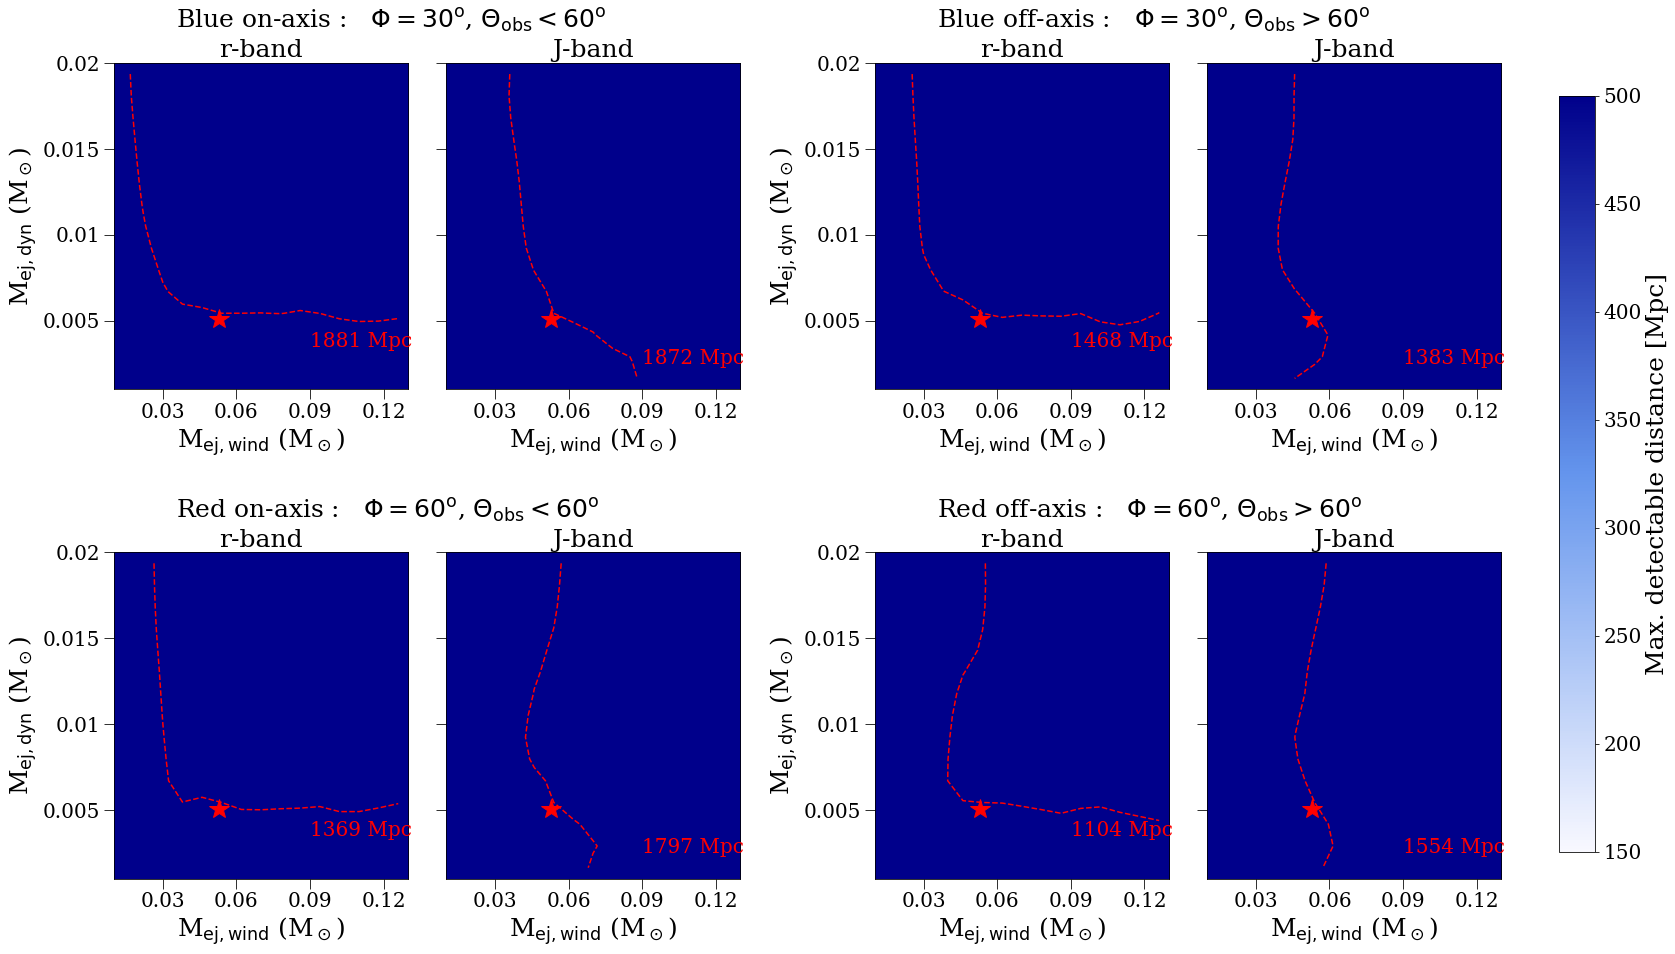

In [9]:
cmap = colors.LinearSegmentedColormap.from_list("",['ghostwhite','cornflowerblue','darkblue'])
tablelist = [r,J]
cols = ['red','orange']
labs = ['r','J']

fig = plt.figure(figsize=(25,15))
gs = GridSpec(2,2,hspace=0.5,wspace=0.2)

axs = []
#is_dets = [[],[]]

#is_dets = [[],[]]
gs1 = gs[0].subgridspec(1,2,wspace=0.1)


phi_plots = [phis[0],phis[-1]]

delim_angle = 60
theta_plot_lims = [(0,delim_angle),(delim_angle,90)]

enum = -1
kn_types = [['Blue on-axis','Blue off-axis'],['Red on-axis','Red off-axis']]
for phi_ind,phi_val in enumerate(phi_plots):
    for theta_ind,theta_lim in enumerate(theta_plot_lims):
        enum = enum+1
        pmarrays = []
        
        max_dms = [[],[]]
        gs1 = gs[enum].subgridspec(1,2,wspace=0.1)
        
        for ind in range(len(tablelist)):
            t = tablelist[ind]
            phi = phi_val
            t1 = t[(t['theta']>=theta_lim[0]) & (t['theta']<theta_lim[1]) & (t['phi']==phi)]
            dmarray = []
            for md in mej_dyns:
                t2 = t1[t1['mej_dyn']==md]
                t2.sort('mej_wind')
                t2 = t2.group_by('mej_wind')
                dmbins = []
                for grp in t2.groups:
                    dmbins.append(m_limiting-np.median(grp['peak_mag']))
                dmarray.append(dmbins)
            
            dmarray = np.array(dmarray)
            max_dms[ind].append(dmarray)
        
        max_dms = np.array(max_dms)
        max_dists = 10*(10**(max_dms/5))/1e6
        
        if phi_ind==0:
            print('Blue')
        else:
            print('Red')
        print('-----')
        
        if theta_lim[1]==delim_angle:
            dists_to_plot = realistic_distances[(realistic_costhetas>np.cos(delim_angle*np.pi/180))]
            print('On-axis r-band : %s/%s kilonovae are too far to be detectable for any part of the parameter space'%(len(dists_to_plot[dists_to_plot>np.max(max_dists[0][0])]),len(dists_to_plot)) )
            print('On-axis r-band : %s/%s kilonovae have GW170817 in the detectable region of parameter space'%(len(dists_to_plot[dists_to_plot<max_dists[0][0][3][5]]),len(dists_to_plot)))
            print('On-axis J-band : %s/%s kilonovae are too far to be detectable for any part of the parameter space'%(len(dists_to_plot[dists_to_plot>np.max(max_dists[1][0])]),len(dists_to_plot)) )
            print('On-axis J-band : %s/%s kilonovae have GW170817 in the detectable region of parameter space'%(len(dists_to_plot[dists_to_plot<max_dists[1][0][3][5]]),len(dists_to_plot)))
        else:
            dists_to_plot = realistic_distances[(realistic_costhetas<np.cos(delim_angle*np.pi/180))]
            print('Off-axis r-band : %s/%s kilonovae are too far to be detectable for any part of the parameter space'%(len(dists_to_plot[dists_to_plot>np.max(max_dists[0][0])]),len(dists_to_plot)))
            print('Off-axis r-band : %s/%s kilonovae have GW170817 in the detectable region of parameter space'%(len(dists_to_plot[dists_to_plot<max_dists[0][0][3][5]]),len(dists_to_plot)))
            print('Off-axis J-band : %s/%s kilonovae are too far to be detectable for any part of the parameter space'%(len(dists_to_plot[dists_to_plot>np.max(max_dists[1][0])]),len(dists_to_plot)))
            print('Off-axis J-band : %s/%s kilonovae have GW170817 in the detectable region of parameter space'%(len(dists_to_plot[dists_to_plot<max_dists[1][0][3][5]]),len(dists_to_plot)))
        print('-----')
        ax = fig.add_subplot(gs1[0])
        im = ax.imshow(max_dists[0][0],extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',aspect=7,vmin=150,vmax=500,cmap=cmap,interpolation='bicubic')
        cs = ax.contour(max_dists[0][0],[max_dists[0][0][3][5]],colors='red',extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='--',linewidth=3)
        cs1 = ax.contour(max_dists[0][0],levels=dists_to_plot,extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='-',alpha=0.6,vmin=150,vmax=500,cmap='magma',linewidth=0.7)
        plt.title('%s-band'%(labs[0]),size=25)
        ax.set_xticks([0.03,0.06,0.09,0.12])
        ax.set_xticklabels([0.03,0.06,0.09,0.12],size=20)
        ax.set_xlabel(r'M$_{\rm{ej, wind}}$ (M$_\odot$)',size=25)
        ax.set_ylabel(r'M$_{\rm{ej, dyn}}$ (M$_\odot$)',size=25)
        ax.set_yticks([0.005,0.01,0.015,0.02])
        ax.set_yticklabels([0.005,0.01,0.015,0.02],size=20)
        ax.tick_params(size=10)
        
        ax.plot(mej_winds[5],mej_dyns[3],'*',c='red',markersize=20)
        ax.text(0.09,0.0035,'%i Mpc'%(max_dists[0][0][3][5]),size=20,color='red')
        
        ax = fig.add_subplot(gs1[1])
        im = ax.imshow(max_dists[1][0],extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',aspect=7,vmin=150,vmax=500,cmap=cmap,interpolation='bicubic')
        cs = ax.contour(max_dists[1][0],[max_dists[1][0][3][5]],colors='red',extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='--',linewidth=3)
        cs1 = ax.contour(max_dists[1][0],levels=dists_to_plot,extent=[mej_winds.min(),mej_winds.max(),mej_dyns.min(),mej_dyns.max()],origin='lower',linestyles='-',alpha=0.6,vmin=150,vmax=500,cmap='magma',linewidth=0.7)
        plt.title('%s-band'%(labs[1]),size=25)
        #ax.set_yticks([0.005,0.01,0.015,0.02])
        ax.set_xticks([0.03,0.06,0.09,0.12])
        ax.set_xticklabels([0.03,0.06,0.09,0.12],size=20)
        ax.set_xlabel(r'M$_{\rm{ej, wind}}$ (M$_\odot$)',size=25)
        ax.set_yticks([0.005,0.01,0.015,0.02])
        ax.set_yticklabels([],size=12)
        ax.tick_params(size=10)
        sign = '>'
        if theta_lim[1] == delim_angle:
            sign = '<'
        ax.text(-0.1,0.022,r'%s :   $\Phi = %i^{\rm{o}}$, $\Theta_{\rm{obs}} %s %s^{\rm{o}}$'%(kn_types[phi_ind][theta_ind],phi,sign,delim_angle),size=25)
        
        ax.plot(mej_winds[5],mej_dyns[3],'*',c='red',markersize=20)
        ax.text(0.09,0.0025,'%i Mpc'%(max_dists[1][0][3][5]),size=20,color='red')

cbar_ax = fig.add_axes([0.93,0.15,0.02,0.7])
cbar = fig.colorbar(im,cax=cbar_ax)
cbar.set_label('Max. detectable distance [Mpc]',size=25)
cbar.set_ticks([150,200,250,300,350,400,450,500])
cbar.set_ticklabels([150,200,250,300,350,400,450,500])
cbar.ax.tick_params(labelsize=20,pad=5)

#plt.savefig('rJ_comparison_ejecta_masses_Bulla_models.pdf',bbox_inches='tight')

# Figure 11

Read in 90\% localization areas and distances for the realistic rate simulation events

<ipython-input-10-cbf6e265e6a8>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  det_fracs = np.array(det_fracs)
<ipython-input-10-cbf6e265e6a8>:43: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax.contour(det_fracs[0],[0.1,0.5,0.9],colors='black',extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',linestyles=['--','-',':'],linewidth=3)
<ipython-input-10-cbf6e265e6a8>:70: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax.contour(det_fracs[1],[0.1,0.5,0.9],colors='black',extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',linestyles=['--','-',':'],linewidth=3)


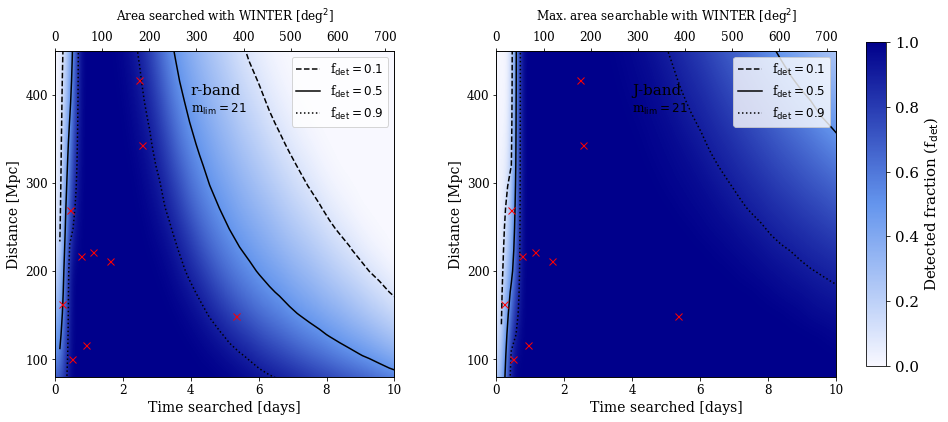

In [10]:
cmap = colors.LinearSegmentedColormap.from_list("",['ghostwhite','cornflowerblue','darkblue'])
labs = ['r','J']
Ds = np.linspace(20,500,20)
tablelist = [r,J]
DMs = 5*np.log10(Ds*1e5)
t_covs = np.arange(0,15,0.3)

fig = plt.figure(figsize=(14,6))
gs = GridSpec(1,2,hspace=0.4,wspace=0.3)

axs = []
delim_angle = 60
theta_plot_lims = [(0,delim_angle),(delim_angle,90)]
enum =-1
phi_plots = [phis[0],phis[-1]]

enum = enum+1
pmarrays = []
        
det_fracs = [[],[]]

for ind in range(len(tablelist)):
    t = tablelist[ind]
    t1 = t


    for DM in DMs:
        fdetarray = []
        for t_cov in t_covs:
            mapps = t1['mag'][:,0]+DM
            t_ind = np.argmin(np.abs(t1[0]['t']-t_cov))
            m_at_cov = mapps[:,t_ind]
            ndet = np.sum(m_at_cov<m_limiting)
            fdet = ndet/len(m_at_cov)
                    
            fdetarray.append(fdet)
        det_fracs[ind].append(fdetarray)    
        
    det_fracs = np.array(det_fracs)
        
ax = fig.add_subplot(gs[0])
im = ax.imshow(det_fracs[0],extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',aspect=0.026,vmin=0,vmax=1,cmap=cmap,interpolation='bicubic')
cs = ax.contour(det_fracs[0],[0.1,0.5,0.9],colors='black',extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',linestyles=['--','-',':'],linewidth=3)

ax.set_ylim(80,450)
ax.set_xlim(0,10)
ax.set_yticks([100,200,300,400])
ax.set_xticks([0,2,4,6,8,10])
ax.set_ylabel(r'Distance [Mpc]',size=14)
ax.set_xlabel(r'Time searched [days]',size=14)

ax.text(4,400,'r-band',size=15)
ax.text(4,380,r'm$_{\rm{lim}} = 21$',size=12)
ax2 = ax.twiny()
ax2.set_xlim(np.array([0,10])*9*3600/450 * 1)
ax2.set_xlabel(r'Area searched with WINTER [deg$^2$]',size=12,labelpad=10)

ax.plot(realistic_area90s/(9*3600/450),realistic_distances,'x',color='red',markersize=7)

ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

ax.plot(0,0, label=r'f$_{\rm{det}} = 0.1$', color='black', ls='--')
ax.plot(0,0, label=r'f$_{\rm{det}} = 0.5$', color='black', ls='-')
ax.plot(0,0, label=r'f$_{\rm{det}} = 0.9$', color='black', ls=':')
ax.legend(fontsize=12)
        
ax = fig.add_subplot(gs[1])
im = ax.imshow(det_fracs[1],extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',aspect=0.026,vmin=0,vmax=1,cmap=cmap,interpolation='bicubic')
cs = ax.contour(det_fracs[1],[0.1,0.5,0.9],colors='black',extent=[t_covs.min(),t_covs.max(),Ds.min(),Ds.max()],origin='lower',linestyles=['--','-',':'],linewidth=3)

ax.set_ylim(80,450)


ax.set_xlim(0,10)
ax.set_yticks([100,200,300,400])
ax.set_xticks([0,2,4,6,8,10])
xticks = np.array([0,2,4,6,8,10])
ax2 = ax.twiny()
ax2.set_xlim(np.array([0,10])*9*3600/(450) * 1)
ax2.set_xlabel(r'Max. area searchable with WINTER [deg$^2$]',size=12,labelpad=10)

ax.plot(realistic_area90s/(9*3600/(450)),realistic_distances,'x',color='red',markersize=7)

ax.set_ylabel(r'Distance [Mpc]',size=14)
ax.set_xlabel(r'Time searched [days]',size=14)


ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax.text(4,400,'J-band',size=15)
ax.text(4,380,r'm$_{\rm{lim}} = 21$',size=12)

cbar_ax = fig.add_axes([0.93,0.15,0.02,0.75])
cbar = fig.colorbar(im,cax=cbar_ax)
cbar.set_label(r'Detected fraction (f$_{\rm{det}}$)',size=15)
cbar.ax.tick_params(labelsize=15,pad=5)

ax.plot(0,0, label=r'f$_{\rm{det}} = 0.1$', color='black', ls='--')
ax.plot(0,0, label=r'f$_{\rm{det}} = 0.5$', color='black', ls='-')
ax.plot(0,0, label=r'f$_{\rm{det}} = 0.9$', color='black', ls=':')

ax.legend(fontsize=12,loc=1)

#plt.savefig(r'tloc_dist_comparisons.pdf',bbox_inches='tight')

# Figure 12

In [36]:
#Set field of view
fov = 1 #sq. deg 

In [37]:
def gen_det_fracs(mlim,tablelist,DMs,t_covs):
    for ind in range(len(tablelist)):
        t = tablelist[ind]
        t1 = t

        det_fracs = [[],[]]
        for DM in DMs:
            fdetarray = []
            for t_cov in t_covs:
                mapps = t1['mag'][:,0]+DM
                t_ind = np.argmin(np.abs(t1[0]['t']-t_cov))
                m_at_cov = mapps[:,t_ind]
                ndet = np.sum(m_at_cov<mlim)
                fdet = ndet/len(m_at_cov)
                    
                fdetarray.append(fdet)
            det_fracs[ind].append(fdetarray)    
        
        det_fracs = np.array(det_fracs)
    return det_fracs

<ipython-input-37-20e054ff1ff3>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  det_fracs = np.array(det_fracs)
<ipython-input-38-44a7e9989f20>:16: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  cs = plt.contour(areas,Ds,det_fracs[1],[0.1],colors='black',origin='lower',linestyles=['--','-'],linewidth=3,label='J = 21 mag')
<ipython-input-38-44a7e9989f20>:24: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  cs = plt.contour(areas,Ds,det_fracs[1],[0.1],colors='blue',origin='lower',linestyles=['--','-'],linewidth=3,label='J = 20 mag')
<ipython-input-38-44a7e9989f20>:32: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  cs = plt.contour(areas,Ds,det_fracs[1],[0.1],color

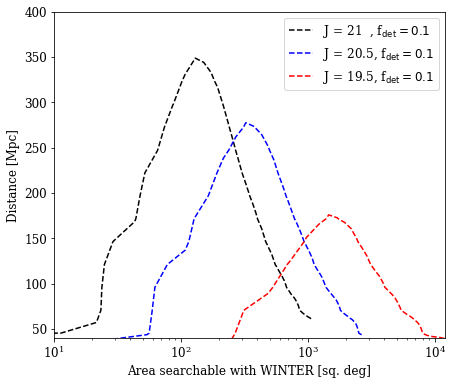

In [38]:
cmap = colors.LinearSegmentedColormap.from_list("",['ghostwhite','cornflowerblue','darkblue'])
labs = ['r','J']
Ds = np.linspace(20,500,20)
tablelist = [r,J]
DMs = 5*np.log10(Ds*1e5)
t_covs = np.arange(0,15,0.3)

fig = plt.figure(figsize=(7,6))

#Set exposure time and limiting magnitude
m_limiting = 21
texp = 450

areas = fov*t_covs*9*3600/(texp) #sq. deg
det_fracs = gen_det_fracs(m_limiting,tablelist,DMs,t_covs)
cs = plt.contour(areas,Ds,det_fracs[1],[0.1],colors='black',origin='lower',linestyles=['--','-'],linewidth=3,label='J = 21 mag')

#Set exposure time and limiting magnitude
m_limiting = 20.5
texp = 180

areas = fov*t_covs*9*3600/(texp)
det_fracs = gen_det_fracs(m_limiting,tablelist,DMs,t_covs)
cs = plt.contour(areas,Ds,det_fracs[1],[0.1],colors='blue',origin='lower',linestyles=['--','-'],linewidth=3,label='J = 20 mag')

#Set exposure time and limiting magnitude
m_limiting = 19.5
texp = 40

areas = fov*t_covs*9*3600/(texp)
det_fracs = gen_det_fracs(m_limiting,tablelist,DMs,t_covs)
cs = plt.contour(areas,Ds,det_fracs[1],[0.1],colors='red',origin='lower',linestyles=['--','-'],linewidth=3,label='J = 19 mag')
plt.xlabel('Area searchable with WINTER [sq. deg]',size=12)
plt.ylabel('Distance [Mpc]',size=12)

plt.xscale('log')
plt.xlim(10)
plt.ylim(40,400)
plt.tick_params(labelsize=12)


plt.plot(0,0, label=r'J = 21  , f$_{\rm{det}} = 0.1$', color='black', ls='--')

plt.plot(0,0, label=r'J = 20.5, f$_{\rm{det}} = 0.1$', color='blue', ls='--')

plt.plot(0,0, label=r'J = 19.5, f$_{\rm{det}} = 0.1$', color='red', ls='--')

plt.legend(fontsize=12)
#plt.savefig(r'tloc_dist_comparisons_contours_Jband.pdf',bbox_inches='tight')